# Machine Learning Capstone Project

## DTSC-691

## Name: Jillian Helmick

This project will include a machine learning fraud detection model for medical claims using the Medicare Provider Utilization and Payment Data (MPPD), specifically the "Physician and Other Supplier" data (MPOP PS and MPOP P). This data, available from the Centers for Medicare & Medicaid Services (CMS), provides detailed information on provider utilization, payments, and charges, and can be linked with information from the Office of Inspector General's (OIG) List of Excluded Individuals/Entities (LEIE) to identify fraudulent providers.


Research question: Can machine learning models (specifically an unsupervised One-Class SVM) detect anomalous Medicare provider behavior indicative of fraud using utilization and payment data?
Objective: Identify unusual provider behavior patterns without relying on extensive labeled data.

The purpose of this project is to develop an advanced fraud detection framework for Medicare provider claims by applying unsupervised machine learning techniques. Fraudulent billing practices cost the U.S. healthcare system billions annually, leading to financial losses and reduced care quality for beneficiaries. Current fraud detection approaches often rely on manually identified patterns or post-hoc investigations, which may fail to detect novel or evolving fraud schemes. This project aims to contribute to the healthcare analytics field by exploring the use of unsupervised learning to proactively identify anomalous billing behaviors that may indicate fraud.

This research focuses on the application of an One-Class Support Vector Machine (SVM) and an Isolation Forest Model to Medicare Provider Utilization and Payment Data (MPOP) to detect anomalous providers. The primary research question is: Can machine learning models accurately predict Medicare provider fraud using utilization and payment data? Key areas of investigation include: identifying patterns of abnormal provider behavior based on claims, payments, and utilization metrics, determining the feasibility of using an unsupervised approach when labeled fraud cases are limited, and validating detection anomalies against the Office of Inspector General’s (OIG) List of Excluded Individuals/Entities (LEIE). 
	
Specific goals include:
Collect and preprocess Medical Provider Utilization and Payment (MPOP) data and integrate it with the OIG LEIE dataset.
Engineer key features that capture financial, utilization, and behavioral characteristics of providers.
Implement a One-Class SVM to model normal provider behavior and flag potential anomalies. 
Evaluate the model’s ability to identify known fraudulent providers using precision, recall, and anomaly score analysis. 
Provide insights into high-risk provider patterns that may inform future CMS/OIG fraud prevention strategies. 

The primary dataset will be the Medicare Provider Utilization and Payment Data (Physician and Other Supplier), also known as the Public Use File (PUF), obtained from the Centers for Medicare & Medicaid Services (CMS). This dataset includes detailed information on provider charges, payments, services, and beneficiaries. The data is organized by National Provider Identifier (NPI) and Healthcare Common Procedure Coding System (HCPCS) code to show how much Medicare pays, what is allowed, and what is billed. To assess model performance, this data will be cross-referenced with the OIG LEIE dataset, version updated on July 7, 2025, which lists providers excluded from federal health programs due to fraudulent or abusive practices. Individuals and entities who have been reinstated are not included in the updated data file. These sources are publicly available, comprehensive, and directly relevant to the problem domain.

## Common Imports

In [ ]:
# Check for Tensorflow 
import subprocess
import sys
from IPython.display import clear_output
def check_tensorflow():
    tf_desired_version = "2.9.2"

    try:
        import tensorflow as tf
        tf_installed_version = tf.__version__
    except ImportError:
        tf_installed_version = None

    #Check for the right version
    if tf_installed_version != tf_desired_version:
        print(f"Current TensorFlow version: {tf_installed_version}. Installing version {tf_desired_version}...")
        
        # Uninstall the current TensorFlow version
        subprocess.check_call([sys.executable, '-m', 'pip', 'uninstall', '-y', 'tensorflow'])
        
        # Install the desired TensorFlow version
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', f'tensorflow=={tf_desired_version}'])

        clear_output()
        
        print(f"TensorFlow version {tf_desired_version} installed successfully. Please restart your kernel to apply the changes.")
    else:
        print(f"TensorFlow version {tf_desired_version} is already installed.")    

check_tensorflow()

In [3]:
# common imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.patches import Rectangle
import pickle
%matplotlib inline

## Load the Data Files

In [6]:
# Define a funtion to load the data then create the fraud flag
# Define the function to load and flag fraud
def load_and_flag(mpop_file: str, leie_file: str) -> pd.DataFrame:
    """
    Loads MPOP and LEIE files, flags fraudulent NPIs.
    """
    mpop = pd.read_csv(mpop_file, dtype={"Rndrng_NPI": str})
    leie = pd.read_csv(leie_file, dtype={"NPI": str})
    mpop["fraud_flag"] = mpop["Rndrng_NPI"].isin(leie["NPI"]).astype(int)
    return mpop

We are matching the data based on the National Provider Identifier (NPI)

Naming our new data set mpop, we're using our function to load the data and implement our fraud flag column.

In [9]:
mpop = load_and_flag("Medicare_Physician_Other_Practitioners_by_Provider_2023.csv", "UPDATED.csv") 

/var/folders/k2/mpk6r_q10_7bw5t1wfb29l680000gn/T/ipykernel_3398/1628478493.py:7: DtypeWarning: Columns (10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  mpop = pd.read_csv(mpop_file, dtype={"Rndrng_NPI": str})
/var/folders/k2/mpk6r_q10_7bw5t1wfb29l680000gn/T/ipykernel_3398/1628478493.py:8: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  leie = pd.read_csv(leie_file, dtype={"NPI": str})


In [12]:
# verify it worked
mpop['fraud_flag'].value_counts()

# 1259211 not fraud and 132 marked as fraud

fraud_flag
0    1259211
1        132
Name: count, dtype: int64

In [14]:
# The data is highly skewed, check if the NPIs are duplicated in the MPOP data file and did not match
dup_counts = mpop["Rndrng_NPI"].value_counts()
print(f"Total NPIs: {len(mpop)}")
print(f"Unique NPIs: {mpop['Rndrng_NPI'].nunique()}")
print(f"Duplicated NPIs: {(dup_counts > 1).sum()}")

Total NPIs: 1259343
Unique NPIs: 1259343
Duplicated NPIs: 0


In [18]:
# Some NPIs in the original MPOP file were 0 if not known or filled in. Let's drop those rows for additonal cleaning. 

mpop = mpop[mpop['Rndrng_NPI'] !=0].copy()
mpop = mpop[mpop['Rndrng_NPI'].notna()]

# check the remaining rows
print(f"Remaining rows: {len(mpop)}")

Remaining rows: 1259343


# Exploratory Data Analysis

In [23]:
# Exploratory data analysis

# Basic overview
mpop.describe(include='all').T  # stats for numeric and categorical columns

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Rndrng_NPI,1259343,1259343,1003000126,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Rndrng_Prvdr_Last_Org_Name,1259343,299218,Smith,6596,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Rndrng_Prvdr_First_Name,1196534,85317,Michael,20640,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Rndrng_Prvdr_MI,793380,32,M,96752,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Rndrng_Prvdr_Crdntls,1095675,18514,MD,261977,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
Bene_CC_PH_Parkinson_V2_Pct,479616.0,NaN,NaN,NaN,2.406248,4.696297,0.0,0.0,0.0,4.0,75.0
Bene_CC_PH_Arthritis_V2_Pct,1138428.0,NaN,NaN,NaN,52.263289,12.337814,0.0,44.0,51.0,60.0,75.0
Bene_CC_PH_Stroke_TIA_V2_Pct,753975.0,NaN,NaN,NaN,14.018461,10.904596,0.0,7.0,11.0,19.0,75.0
Bene_Avg_Risk_Scre,1259343.0,NaN,NaN,NaN,1.571429,0.810715,0.3253,1.0216,1.3374,1.921,13.6596


In [24]:
# Fraud vs non-fraud counts
mpop['fraud_flag'].value_counts()

fraud_flag
0    1259211
1        132
Name: count, dtype: int64

Now, let's check some basic statistical grouping. 

The main research question asks us to find fraud associated with providers in both datasets. Let's begin looking at the most substantial columns associated with this purpose.

Med_Mecr_Alowd_Amt is the Medicare allowed amount for medical (non- ASP) services. This figure is the sum of the amount Medicare pays, the deductible and coinsurance amounts that the beneficiary is responsible for paying, and any amounts that a third party is responsible for paying.

Med_Medcr_Pymt_Amt is the total amount that Medicare paid after deductible and coinsurance amounts have been deducted for all of the provider's line item medical (non-ASP) services.

In [30]:
# Compare some key metrics by fraud flag
#print(mpop.columns) # check column names
mpop.groupby('fraud_flag')[['Med_Mdcr_Alowd_Amt', 
                              'Med_Mdcr_Pymt_Amt']].mean()

,Med_Mdcr_Alowd_Amt,Med_Mdcr_Pymt_Amt
fraud_flag,,
0,91483.419804,72139.808347
1,163832.407019,133722.092019


# Visualizations

Let's look further into financial disparities associated with providers. 

Med_Sbmtd_Chrg is the total charges that the provider submitted for medical (non-ASP) services.

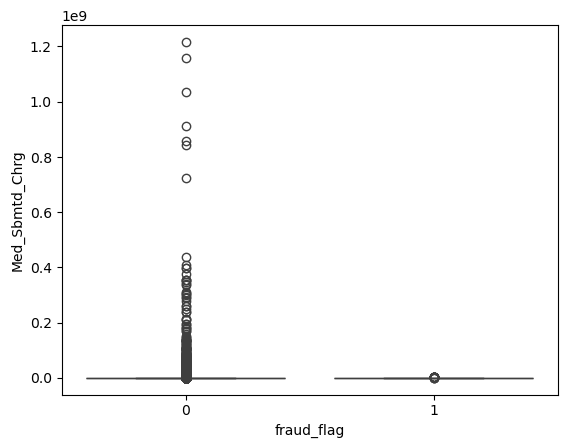

In [33]:
# Visualize distributions
# Submitted medical charge amounts
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x='fraud_flag', y='Med_Sbmtd_Chrg', data=mpop)
plt.show()

Med_Mecr_Alowd_Amt is the Medicare allowed amount for medical (non- ASP) services. This figure is the sum of the amount Medicare pays, the deductible and coinsurance amounts that the beneficiary is responsible for paying, and any amounts that a third party is responsible for paying.

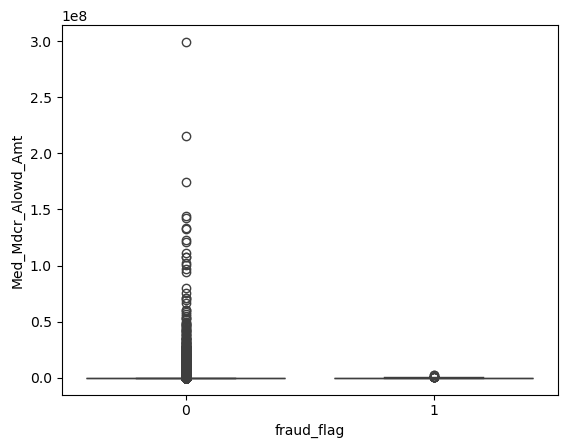

In [39]:
# Medical Medicare Allowed Amount
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x='fraud_flag', y='Med_Mdcr_Alowd_Amt', data=mpop)
plt.show()

Med_Medcr_Pymt_Amt is the total amount that Medicare paid after deductible and coinsurance amounts have been deducted for all of the provider's line item medical (non-ASP) services.

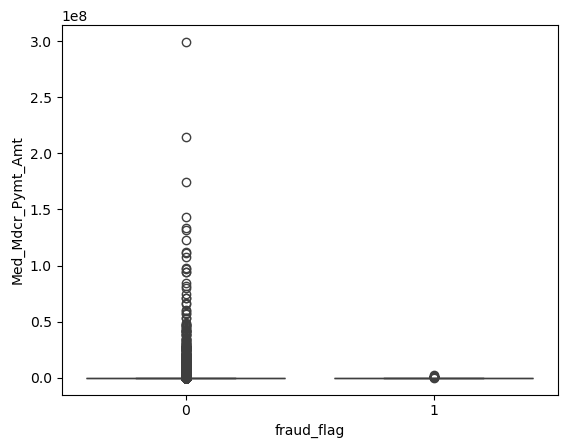

In [51]:
# Medical Medicare Payment Amount
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x='fraud_flag', y='Med_Mdcr_Pymt_Amt', data=mpop)
plt.show()

Tot_Mdcr_Pymt_Amt is the total amount that Medicare paid after deductible and coinsurance amounts have been deducted for all the provider's line item services.

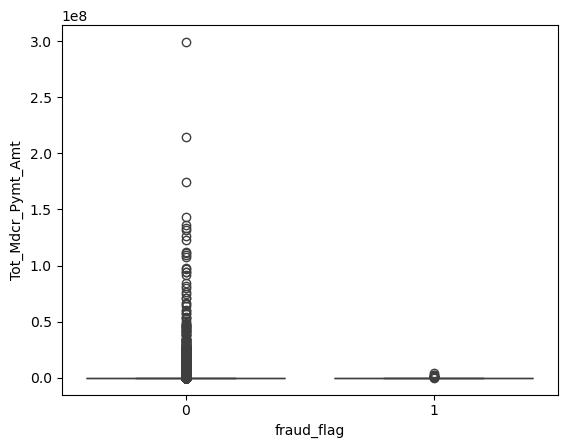

In [53]:
# Total Medicare Payment Amount
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x='fraud_flag', y='Tot_Mdcr_Pymt_Amt', data=mpop)
plt.show()

Tot_Mdcr_Alowd_Amt is the Medicare allowed amount for all provider services. This figure is the sum of the amount Medicare pays, the deductible and coinsurance amounts that the beneficiary is responsible for paying, and any amounts that a third party is responsible for paying.

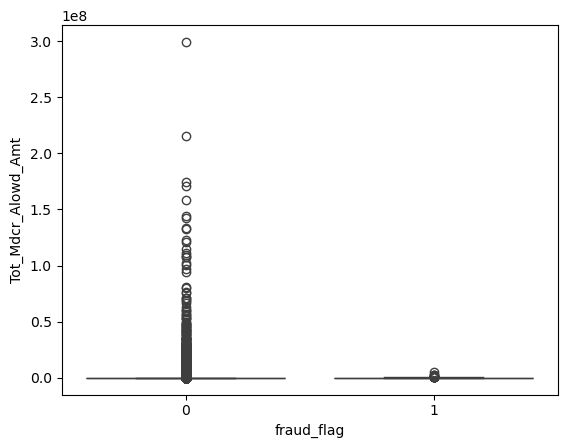

In [55]:
# Total Medicare Allowed Amount
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x='fraud_flag', y='Tot_Mdcr_Alowd_Amt', data=mpop)
plt.show()

Tot_Sbmtd_Chrg is the total charges that the provider submitted for all services.

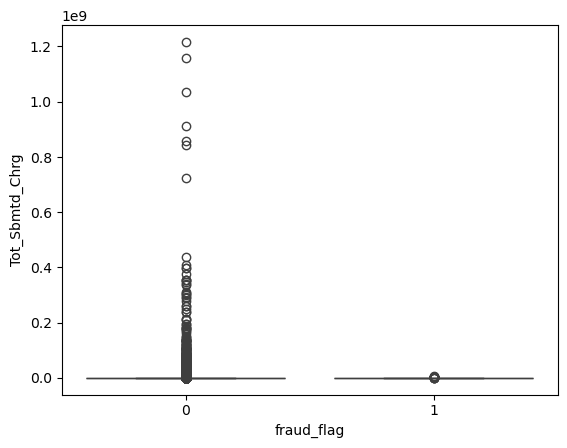

In [58]:
# Total Submitted Charge Amount
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x='fraud_flag', y='Tot_Sbmtd_Chrg', data=mpop)
plt.show()

Let's look at a distribution of total medicare payment amounts and the total medicare allowed amount. We'll cross verify these columns with the Tot_Srvcs column, which refers to the total provider services. 

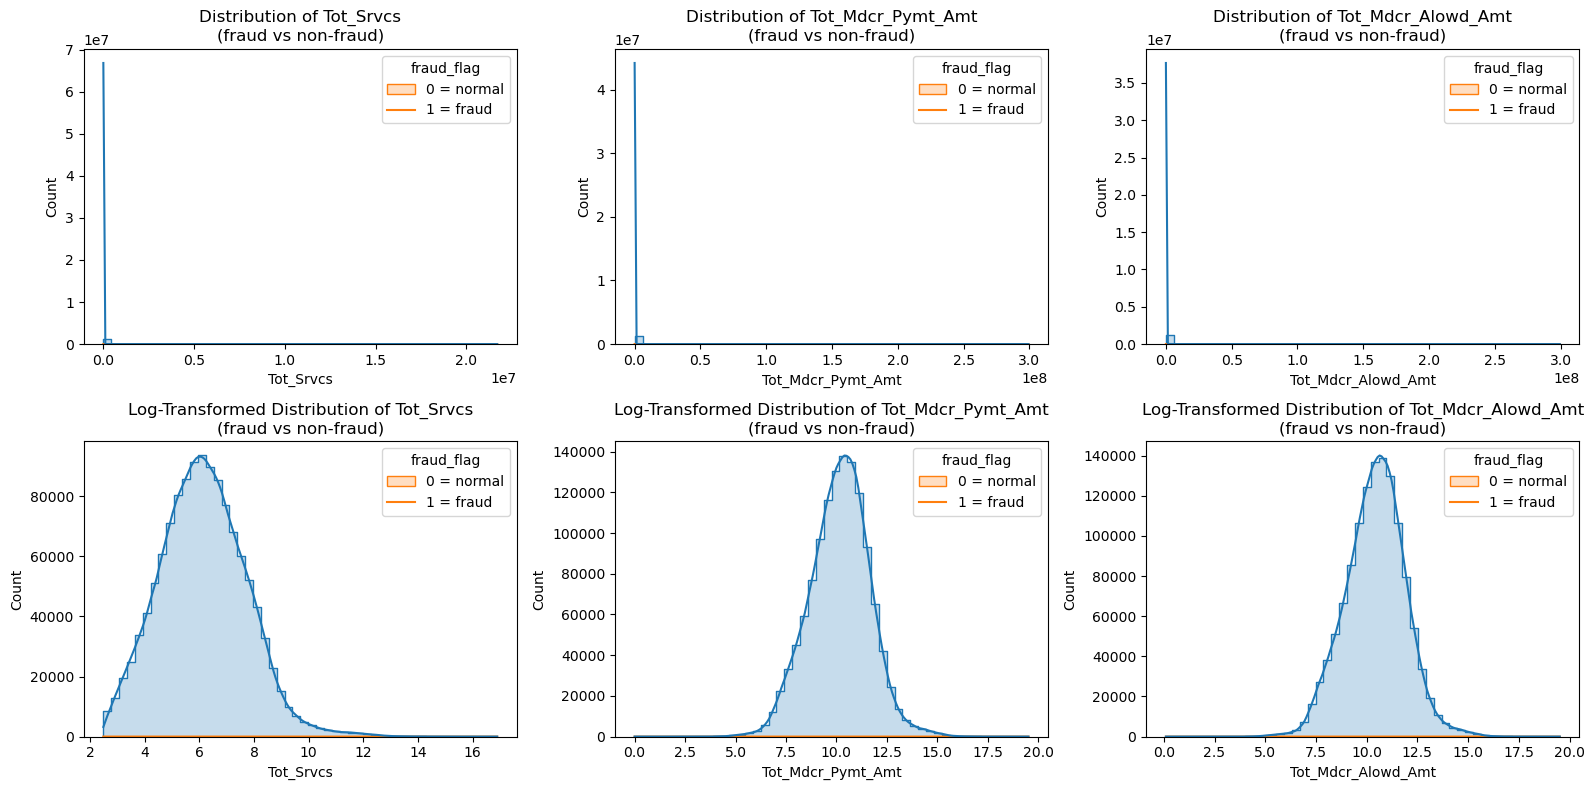

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns

# Distribution of Total Medicare Payment Amount and Total Medicare Allowed Amount
charge_col = 'Tot_Srvcs'           # total services rendered
payment_col = 'Tot_Mdcr_Pymt_Amt'  # total or average Medicare payments
allowed_col = 'Tot_Mdcr_Alowd_Amt'  # allowed amount

cols_to_plot = [charge_col, payment_col, allowed_col]

plt.figure(figsize=(16, 8))

for i, col in enumerate(cols_to_plot, 1):
    plt.subplot(2, len(cols_to_plot), i)
    sns.histplot(data=mpop, x=col, hue='fraud_flag', bins=50, kde=True, element="step")
    plt.title(f'Distribution of {col}\n(fraud vs non-fraud)')
    plt.legend(title="fraud_flag", labels=["0 = normal", "1 = fraud"])

    # Also plot log-scale to handle skewness
    plt.subplot(2, len(cols_to_plot), i+len(cols_to_plot))
    sns.histplot(data=mpop, x=np.log1p(mpop[col]), hue='fraud_flag', bins=50, kde=True, element="step")
    plt.title(f'Log-Transformed Distribution of {col}\n(fraud vs non-fraud)')
    plt.legend(title="fraud_flag", labels=["0 = normal", "1 = fraud"])

plt.tight_layout()
plt.show()

The data is still representing high skew. To attempt to reconcile this, we'll analyze the log scale.

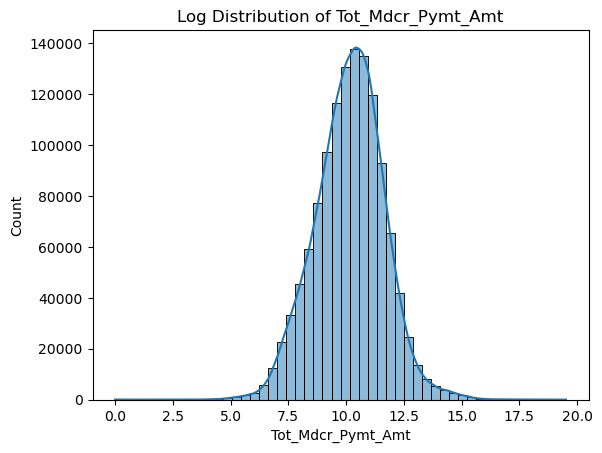

In [68]:
#data is highly skewed, let's look at the log scale

sns.histplot(np.log1p(mpop[payment_col]), bins=50, kde=True)
plt.title(f'Log Distribution of {payment_col}')
plt.show()

To further understand providers, we'll run a correlation analysis between provider attributes and payment behaviors. 

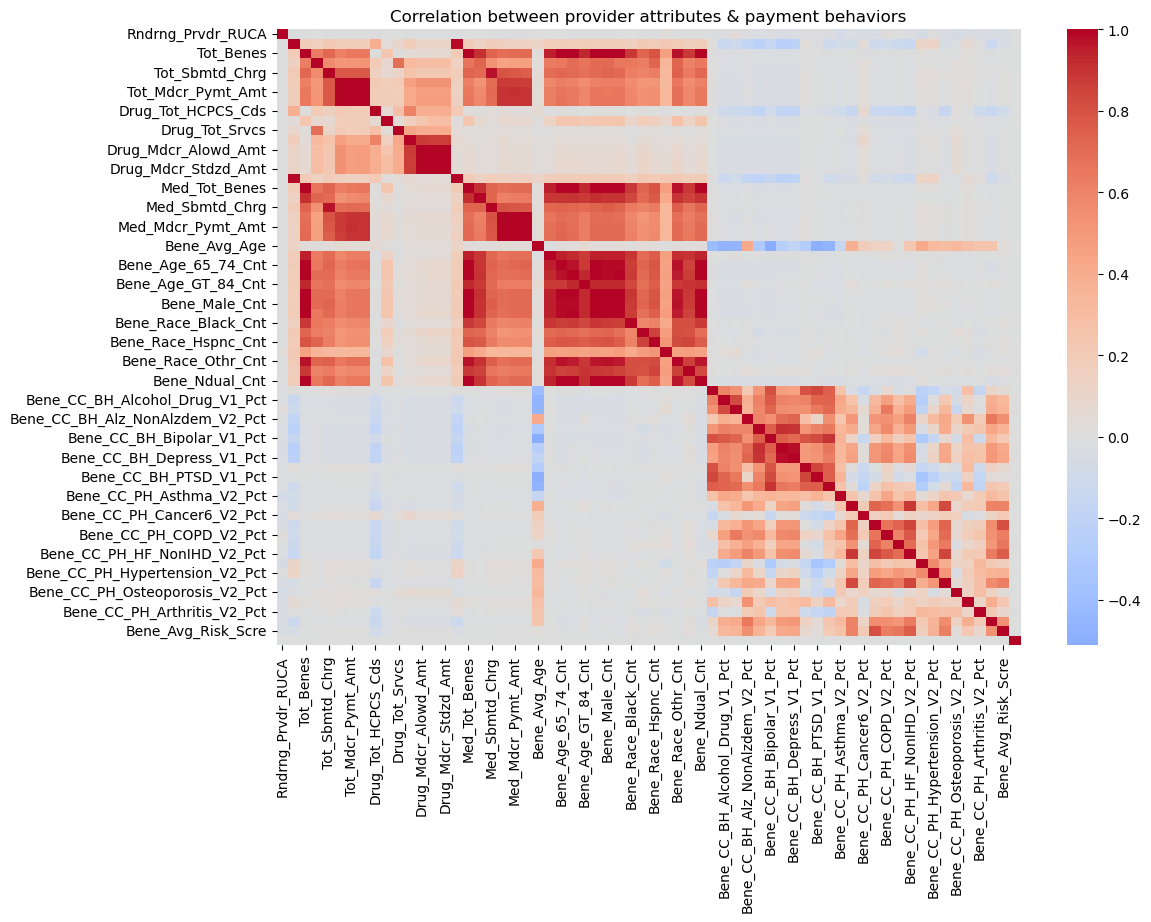

In [71]:
# correlation analysis between provider attributes and payment behaviors

# Select numeric columns only
numeric_df = mpop.select_dtypes(include='number')

# Compute correlation matrix
corr = numeric_df.corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title('Correlation between provider attributes & payment behaviors')
plt.show()

Finally, we'll look at the most prominant financial metrics. 

Using the same data in our distribution plot, we'll run a correlation analysis as a heat map. 

charge_col = 'Tot_Srvcs'           (total services rendered)

payment_col = 'Tot_Mdcr_Pymt_Amt'  (total or average Medicare payments)

allowed_col = 'Tot_Mdcr_Alowd_Amt'  (allowed amount)

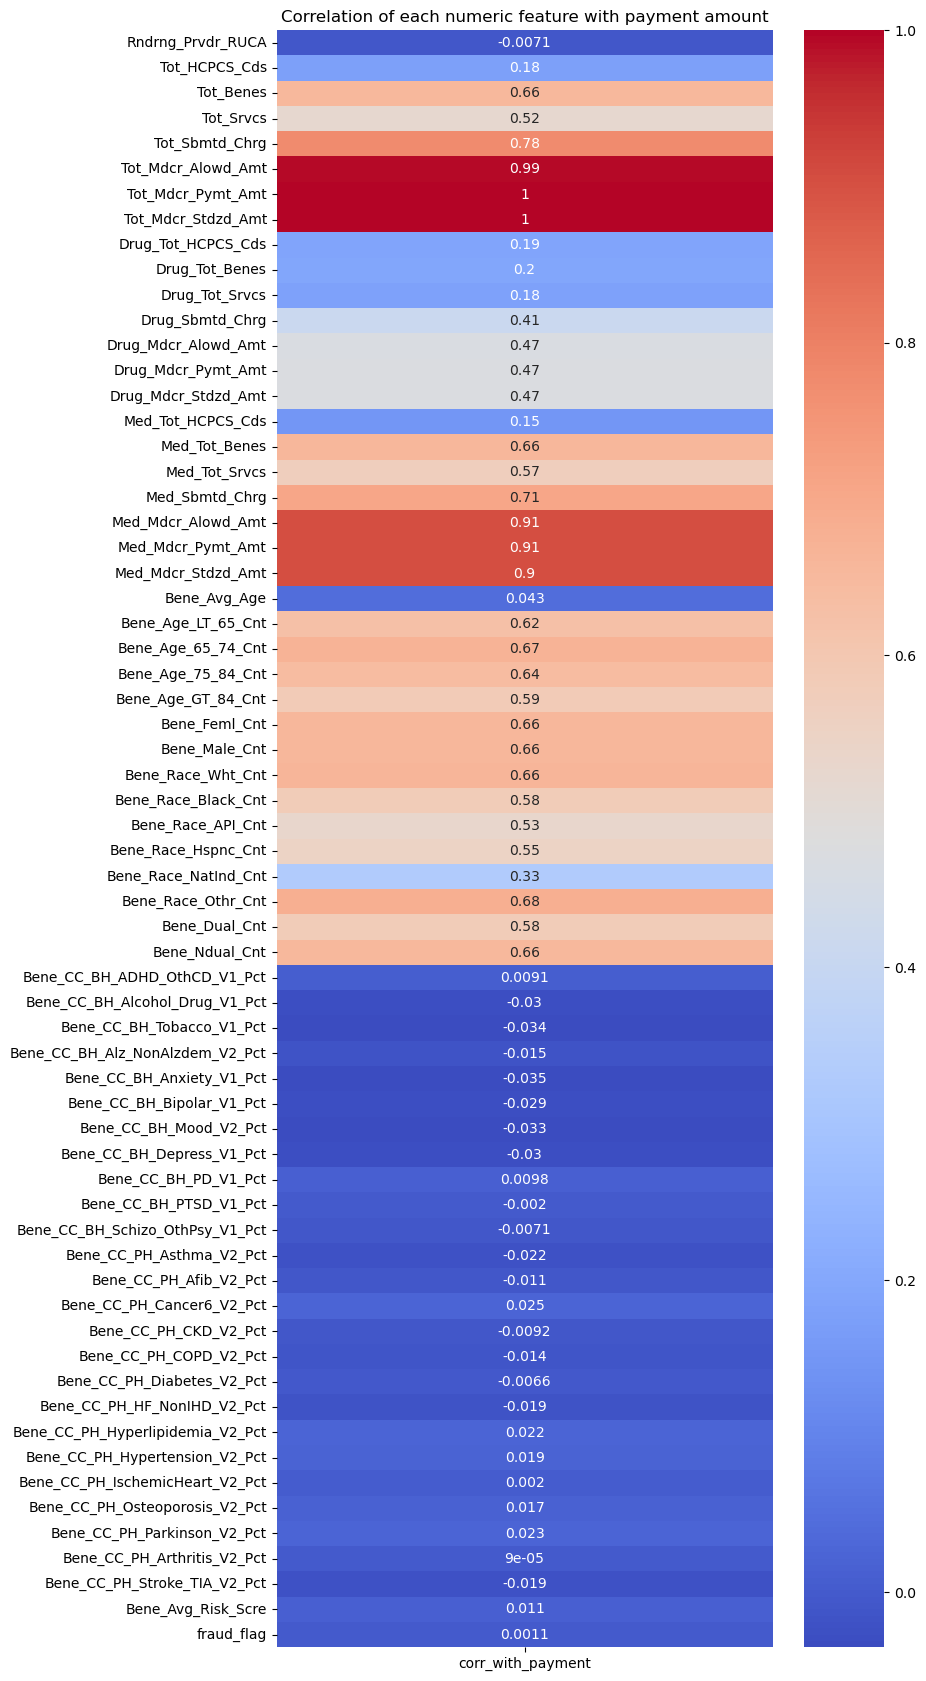

In [74]:
# correlation of our most important financial metrics
target_metrics = [payment_col, allowed_col, charge_col]

plt.figure(figsize=(8, len(numeric_df.columns)//3))
sns.heatmap(
    numeric_df.corrwith(mpop[payment_col]).to_frame(name='corr_with_payment'),
    annot=True, cmap='coolwarm')
plt.title('Correlation of each numeric feature with payment amount')
plt.show()

Before continuing, we can make some assumptions regarding the data integrity of these files. 

First, the high skew is due to the distribution of matches in between the datasets. This could reflect the lack of finaincial fraud committed by Medicare providers. However, it may also be due to the integrity of the data. As I stated before, the OIG LEIE dataset, version updated on July 7, 2025, lists providers excluded from federal health programs due to fraudulent or abusive practices. Individuals and entities who have been reinstated are not included in the updated data file. 

The MPOP data file lacks a date column in which a provider was added to the dataset. Therefore, without limiting the data to a specific date range, we are using unverifiable data from a smaller stretch of time in the OIG LEIE dataset compared to the MPOP data. 

## Data Cleaning and Wrangling

To attempt to wrangle this highly skewed data, we'll begin by establishing our most important columns.

In [78]:
# Impute and flag outliers
core_cols = ["Med_Mdcr_Pymt_Amt", "Tot_Srvcs", "Tot_Benes", "Tot_Sbmtd_Chrg", "Med_Mdcr_Alowd_Amt"]

Then, we'll remove duplicates and invalid NPIs.

In [81]:
# remove duplicates and invalid NPIs
# Drop duplicates based on NPI
# Drop rows with invalid or blank NPIs
def clean_npi(df: pd.DataFrame) -> pd.DataFrame:
    """
    1) Drop duplicate NPIs
    2) Filter out any rows where Rndrng_NPI isn’t purely numeric
    """
    df = df.drop_duplicates(subset="Rndrng_NPI")
    mask = df["Rndrng_NPI"].str.isnumeric()
    return df.loc[mask].copy()

To handle missing values, we'll use iterative imputation. However, with a data file this large (over 80 columns), simple imputation will be incorporated to ensure speed and accuracy. This approach preserves relationships between variables and provides more accurate estimates than simple mean imputation.

Finally, we'll incorporate IQR to identify outliers per row. 

In [93]:
# use iterative imputation to handle missing values
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.linear_model import BayesianRidge

# Define a function to identify numeric columns
def impute_and_flag_outliers(df, core_cols):
    # a) Identify all numeric columns
    num_cols = df.select_dtypes(include="number").columns.tolist()

    # Fast median imputation
    median_imp = SimpleImputer(strategy="median")
    df[num_cols] = median_imp.fit_transform(df[num_cols])

    # Iterative imputation on core features
    iter_imp = IterativeImputer(
        estimator=BayesianRidge(),
        max_iter=10,
        n_nearest_features=min(15, len(core_cols)),
        random_state=42,
    )
    df[core_cols] = iter_imp.fit_transform(df[core_cols])

    # Count IQR outliers per row
    df["outlier_count"] = 0
    for col in num_cols:
        q1, q3 = df[col].quantile([0.25, 0.75])
        iqr = q3 - q1
        mask = (df[col] < q1 - 1.5 * iqr) | (df[col] > q3 + 1.5 * iqr)
        df["outlier_count"] += mask.astype(int)

    return df
    
# now call the new data frame
mpop_clean = impute_and_flag_outliers(mpop, core_cols)

For outliers, we'll calculate the IQR and flag values below Q1 and above Q3 for numerical values. For categorical values, we'll group uncommon variables as “other” rather than removal, as removal may alter target values.

We'll also normalize and scale continuous variables to standardize input ranges for SVM. 

Finally, we'll encode categorical variables such as provider specialty and geographic location using one-hot encoding.

In [97]:
# Categorical column wrangling
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# Define a function for categorical columns
def make_categorical_pipeline(df: pd.DataFrame, top_k: int = 20):
    # Identify all object/category columns
    cats = df.select_dtypes(include=["object", "category"]).columns.tolist()
    
    # Group infrequencies
    def bucket_top_k(series, k=top_k):
        top = series.value_counts(dropna=False).nlargest(k).index
        return series.where(series.isin(top), other="Other")
    
    # Apply bucketing
    df[cats] = df[cats].apply(bucket_top_k)
    
    # Onehot encode categorical columns and column transform the rest
    cat_encoder = OneHotEncoder(
        drop="first",
        sparse=False,
        handle_unknown="ignore"
    )
    return ColumnTransformer(
        [("onehot", cat_encoder, cats)],
        remainder="passthrough"
    )

Now, we'll engineer our new features to create indicators such as average payment-to-charge ratio, number of unique beneficiaries, and total services rendered.

In [100]:
# Build new columns
from sklearn.base import BaseEstimator, TransformerMixin

# create a function that returns new column calculations
class FraudFeatureBuilder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        safe_div = lambda a, b: (
            a.div(b)
             .replace([np.inf, -np.inf], 0)
             .fillna(0)
        )
    
        X["payment_to_charge_ratio"] = safe_div(X["Med_Mdcr_Pymt_Amt"], X["Med_Mdcr_Alowd_Amt"])
        X["services_per_bene"]        = safe_div(X["Tot_Srvcs"], X["Tot_Benes"])
        X["payment_per_service"]      = safe_div(X["Med_Mdcr_Pymt_Amt"], X["Tot_Srvcs"])
        X["charge_per_service"]       = safe_div(X["Tot_Sbmtd_Chrg"], X["Tot_Srvcs"])
        return X

To ensure our Pipeline runs correctly, we'll change all categorical variables to string types.

In [109]:
# Change all categorical columns to a string type before running Pipeline
categorical_cols = mpop_clean.select_dtypes(include=["object", "category"]).columns.tolist()
mpop_clean[categorical_cols] = mpop_clean[categorical_cols].astype(str)

# Identify numeric columns (after imputation/outlier flagging)
numeric_cols = mpop_clean.select_dtypes(include=["number"]).columns.tolist()

Finally, assemble and apply the full pipeline. 

In [112]:
# Assemble and apply the full pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

cat_ct = make_categorical_pipeline(mpop_clean)
full_pipeline = Pipeline([
    ("features", FraudFeatureBuilder()),
    ("encode",   cat_ct),
    ("scale",    StandardScaler())
])

# Drop the target column before fit/transform
X_prepared = full_pipeline.fit_transform(mpop_clean.drop(columns=["fraud_flag"]))
y_prepared = mpop_clean["fraud_flag"].values

# Inspect the result
print("Prepared shape:", X_prepared.shape)

/Applications/anaconda3/envs/dtsc680/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Prepared shape: (1259343, 349)


## Model Training

We'll create two unsupervided models to compare. We'll begin with the support vector machine (SVM)

### One-Class SVM 

In [119]:
# Prepare features
X = full_pipeline.transform(mpop_clean.drop(columns=['fraud_flag']))
y = mpop_clean['fraud_flag'].values

Due to the large number of columns and rows after our pipeline build and feature engineering, we'll limit the number of iterations to a random 50,000 rows of data. 

In [121]:
# Model Training
from sklearn.svm import OneClassSVM
from sklearn.metrics import classification_report, confusion_matrix

# Subsample up to N normals (50k)
rng = np.random.RandomState(42)
normal_indices = np.where(y== 0)[0] # Non-Fraud Flagged
n_sample = min(len(normal_indices), 50_000)

sampled_normals = rng.choice(normal_indices, size=n_sample, replace=False)
X_train = X[sampled_normals] # apply to our data

We'll instantiate and fit our model now.

In [125]:
# instantiate the model and fit it
ocsvm = OneClassSVM(kernel='rbf', gamma='scale', nu=0.01, cache_size=1024)
ocsvm.fit(X_train)

OneClassSVM(cache_size=1024, nu=0.01)

### Isolation Forest Model

Now, we'll build our Isolation Forest Model.

We'll use the same variables as above:

X = full_pipeline.transform(mpop_clean.drop(columns=['fraud_flag']))

y = mpop_clean['fraud_flag'].values


We'll first subset our data to speed up training on our Isolation Forest due to the size of our dataframe. 

In [130]:
# Subsample normals to speed up training
rng            = np.random.RandomState(42)
normal_idx     = np.where(y == 0)[0]
n_train        = min(len(normal_idx), 50_000)
sampled_norms  = rng.choice(normal_idx, size=n_train, replace=False)
X_train_norms  = X[sampled_norms]

print(f"Training IsolationForest on {X_train_norms.shape[0]} normal samples")

Training IsolationForest on 50000 normal samples


Now, we'll build our model. We'll use a larger number of n_estimators to develop smoother scores.

In [141]:
from sklearn.ensemble import IsolationForest

iso = IsolationForest(n_estimators=300,      # more trees -> smoother scores
                    max_samples=256,         # subsample per tree; small values speed up & add randomness
                    contamination=0.001,     # expected anomaly rate
                    max_features=1.0,       
                    bootstrap=False,
                    random_state=42,
                    n_jobs=-1)
iso.fit(X)

IsolationForest(contamination=0.001, max_samples=256, n_estimators=300,
                n_jobs=-1, random_state=42)

## Model Evaluation

Finally, we'll compare our models and their performance.

### One-Class SVM

We'll begin by using the predict() function to get the anomoly scores and predictions. -1 will represent out outliers and 1 will represent out inliers. 

In [146]:
# Model Evaluation
# Get anomaly scores and predictions
# Convert predictions: One-Class SVM outputs -1 (outlier) or 1 (inlier)
preds = (ocsvm.predict(X) == -1).astype(int)

In [148]:
# Evaluate with Fraud Flag
from sklearn.metrics import classification_report, confusion_matrix

print("Confusion Matrix:")
print(confusion_matrix(y, preds))

print("\nClassification Report:")
print(classification_report(y, preds, target_names=['Normal','Fraud']))

Confusion Matrix:
[[1231777   27434]
 [    128       4]]

Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      0.98      0.99   1259211
       Fraud       0.00      0.03      0.00       132

    accuracy                           0.98   1259343
   macro avg       0.50      0.50      0.49   1259343
weighted avg       1.00      0.98      0.99   1259343



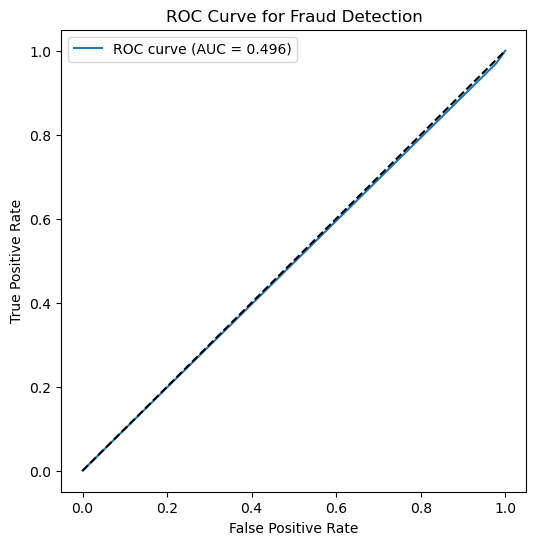

In [150]:
# ROC Curve and AUC
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y, -preds)  # invert because lower = more anomalous
roc_auc = roc_auc_score(y, -preds)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Fraud Detection")
plt.legend()
plt.show()

In [152]:
# decision_function: negative = outlier, positive = inlier
pred_labels = ocsvm.decision_function(X)

In [156]:
# Analyze Top Ranked Anomolies
results_df = mpop_clean.copy()
results_df['anomaly_score'] = preds
results_df['anomaly_flag'] = pred_labels

# Sort so most anomalous providers are at top
top_anomalies = results_df.sort_values('anomaly_score').head(20)
top_anomalies[['Rndrng_NPI', 'anomaly_score', 'fraud_flag']].head(20)

,Rndrng_NPI,anomaly_score,fraud_flag
629671,Other,0,0.0
834799,Other,0,0.0
834798,Other,0,0.0
834797,Other,0,0.0
834796,Other,0,0.0
834795,Other,0,0.0
834794,Other,0,0.0
834793,Other,0,0.0
834792,Other,0,0.0
834791,Other,0,0.0


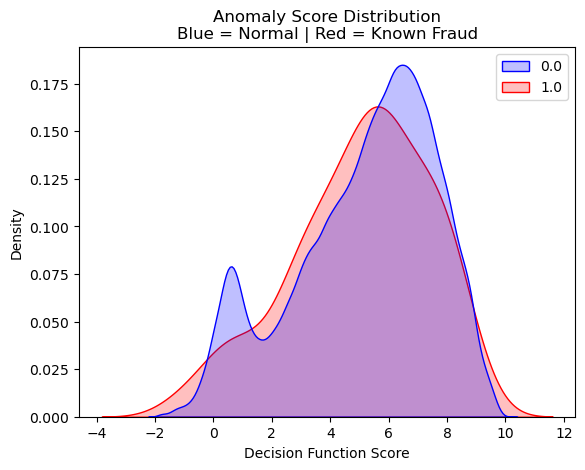

In [158]:
# Visulaize Anamoly Score Distributions
import seaborn as sns

sns.kdeplot(x=pred_labels, hue=y, fill=True, common_norm=False, 
            palette={0: "blue", 1: "red"})
plt.title("Anomaly Score Distribution\nBlue = Normal | Red = Known Fraud")
plt.xlabel("Decision Function Score")
plt.show()

### Isolation Forest Model

In [161]:
# Get anomoly scores and predictions
iso_pred = iso.predict(X)
iso_flag = (iso_pred == -1).astype(int)  # 1 = anomaly

#decision_function: higher = more normal, lower = more anomalous (same convention as OCSVM in sklearn).
#predict: returns 1 (inlier) or -1 (outlier).

Confusion Matrix:
[[1257952    1259]
 [    131       1]]

Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00   1259211
       Fraud       0.00      0.01      0.00       132

    accuracy                           1.00   1259343
   macro avg       0.50      0.50      0.50   1259343
weighted avg       1.00      1.00      1.00   1259343

ROC-AUC (IsolationForest): 0.4967
Average Precision (IsolationForest): 0.0001


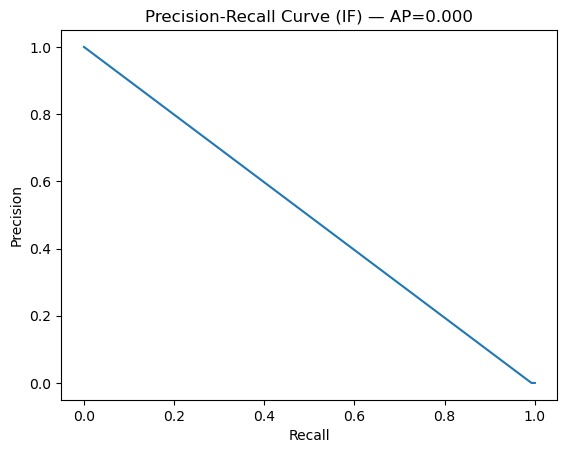

In [164]:
# Evaluate
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Evaluate performance
print("Confusion Matrix:")
print(confusion_matrix(y, iso_flag))

print("\nClassification Report:")
print(classification_report(
    y,
    iso_flag,
    target_names=["Normal", "Fraud"]
))

# ROC (use -scores because lower = more anomalous)
roc_auc_iso = roc_auc_score(y, -iso_flag)
print(f"ROC-AUC (IsolationForest): {roc_auc_iso:.4f}")

# Precision-Recall (more informative for rare fraud)
prec, rec, thresh = precision_recall_curve(y, -iso_flag)
ap_iso = average_precision_score(y, -iso_flag)
print(f"Average Precision (IsolationForest): {ap_iso:.4f}")

plt.figure()
plt.plot(rec, prec)
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title(f"Precision-Recall Curve (IF) — AP={ap_iso:.3f}")
plt.show()

According to the confusion matrix, the Isolation FOrest model runs better than the SVM due to the number of false positives:

ocsvm = 27434

iso = 1259

In [173]:
# Inspect top suspicious providers
mpop_clean["iso_score"] = iso.decision_function(X)  # higher → more normal
mpop_clean["iso_flag"]  = iso_flag

top20_iso = mpop_clean.nsmallest(20, "iso_score")
print("\nTop 20 anomalies by IsolationForest score:")
print(top20_iso[[
    "Rndrng_NPI",
    "iso_score",
    "fraud_flag",
    "iso_flag"
]])


Top 20 anomalies by IsolationForest score:
        Rndrng_NPI  iso_score  fraud_flag  iso_flag
773092       Other  -0.097739         0.0         1
878898       Other  -0.096947         0.0         1
1179069      Other  -0.094666         0.0         1
680239       Other  -0.090968         0.0         1
104068       Other  -0.090434         0.0         1
80562        Other  -0.089587         0.0         1
740316       Other  -0.089324         0.0         1
122084       Other  -0.088242         0.0         1
340818       Other  -0.087475         0.0         1
1202214      Other  -0.085541         0.0         1
1218474      Other  -0.085416         0.0         1
446012       Other  -0.084582         0.0         1
201566       Other  -0.082661         0.0         1
329223       Other  -0.082586         0.0         1
392197       Other  -0.082221         0.0         1
973551       Other  -0.081938         0.0         1
295583       Other  -0.080931         0.0         1
1092471      Other  

## Compare One-Class SVM and Isolation Forest Model

In [175]:
from sklearn.metrics import f1_score, precision_score, recall_score, average_precision_score, roc_auc_score
import pandas as pd

def summarize(y_true, y_pred_binary, anomaly_scores, model_name):
    """
    Summarizes key metrics for anomaly detection models.
    
    Parameters:
    - y_true: Ground truth labels (0 or 1)
    - y_pred_binary: Predicted binary labels (0 or 1)
    - anomaly_scores: Raw anomaly scores (higher = more anomalous)
    - model_name: Name of the model
    
    Returns:
    - Dictionary of evaluation metrics
    """
    return {
        "model": model_name,
        "precision": precision_score(y_true, y_pred_binary, zero_division=0),
        "recall": recall_score(y_true, y_pred_binary, zero_division=0),
        "f1": f1_score(y_true, y_pred_binary, zero_division=0),
        "roc_auc": roc_auc_score(y_true, anomaly_scores),
        "avg_precision": average_precision_score(y_true, anomaly_scores),
    }

# Example usage
summary = []

# Isolation Forest
summary.append(summarize(y, iso_flag, iso_pred, "IsolationForest"))

# One-Class SVM
summary.append(summarize(y, preds, pred_labels, "OneClassSVM"))

# Display results
pd.DataFrame(summary)

,model,precision,recall,f1,roc_auc,avg_precision
0,IsolationForest,0.000794,0.007576,0.001437,0.496712,0.000104
1,OneClassSVM,0.000146,0.030303,0.000290,0.479604,0.000098


In [177]:
import joblib

# Save One-Class SVM
joblib.dump(iso, "isolation_forest_model.pkl")

['isolation_forest_model.pkl']

In [179]:
import joblib

# Save One-Class SVM
joblib.dump(ocsvm, "one_class_svm_model.pkl")

['one_class_svm_model.pkl']

## Voila User Interface

In [181]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import pandas as pd
import joblib

# Load model once
model = joblib.load("isolation_forest_model.pkl")

# Create widgets
threshold_slider = widgets.FloatSlider(
    value=0.5, min=0, max=1, step=0.01, description="Threshold:"
)
file_upload = widgets.FileUpload(
    accept=".csv", multiple=False, description="Upload CSV"
)
run_button = widgets.Button(description="Run Model", button_style="primary")
output_area = widgets.Output()

def on_run_clicked(b):
    output_area.clear_output()
    with output_area:
        if not file_upload.value:
            print("Please upload a CSV first.")
            return
        (name, fileinfo), = file_upload.value.items()
        df = pd.read_csv(pd.io.common.BytesIO(fileinfo["content"]))
        scores = model.predict_proba(df)[:, 1]  # adjust for your model type
        preds = (scores >= threshold_slider.value).astype(int)
        result = pd.DataFrame({"score": scores, "prediction": preds})
        display(result.head(10))  # preview first 10 rows

run_button.on_click(on_run_clicked)

display(threshold_slider, file_upload, run_button, output_area)

FloatSlider(value=0.5, description='Threshold:', max=1.0, step=0.01)

FileUpload(value=(), accept='.csv', description='Upload CSV')

Button(button_style='primary', description='Run Model', style=ButtonStyle())

Output()

### Launch Voila in Browser

In [2]:
#voila Helmick_691_HealthcareFraud.ipynb
#run in bash for deployment

## Additional Configuration

In [ ]:
# ==== CONFIG (edit these) ====
#LABEL_COL = "fraud_flag"        # set to None if unlabeled uploads
#ID_COLS   = ["Rndrng_NPI"]      # any ID cols to ignore if present in uploads
#MODEL_FILES = {
  #  "IsolationForest": "isolation_forest_model.pkl",
   # "OneClassSVM":    "one_class_svm_model.pkl",
#}
# =============================

import numpy as np, pandas as pd, joblib
from sklearn.metrics import (
    precision_recall_fscore_support, roc_auc_score,
    precision_recall_curve, average_precision_score
)
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer

def load_model(path):
    return joblib.load(path)

def infer_expected_cols(df):
    """Use all non-label, non-ID columns from the uploaded CSV (numeric + object).
       If you have a fixed training order, replace this with your explicit list."""
    cols = [c for c in df.columns if c not in ([LABEL_COL] if LABEL_COL else []) + ID_COLS]
    return cols

def scores_from_estimator(est, X, model_name):
    """
    Return anomaly/positive scores in [0,1].
    - Classifiers with predict_proba -> positive class prob (already [0,1])
    - IsolationForest/OCSVM -> convert to anomaly scores where higher => 'more fraudulent'
    """
    # Classifier path
    if hasattr(est, "predict_proba"):
        return est.predict_proba(X)[:, 1].astype(float)

    # Unsupervised/anomaly: map to "fraud-likelihood" style scores
    if hasattr(est, "score_samples"):
        raw = -est.score_samples(X)  # negate: higher -> more anomalous
    elif hasattr(est, "decision_function"):
        raw = -est.decision_function(X)  # negate margin: higher -> more anomalous
    else:
        # last resort: hard predictions
        pred = est.predict(X).astype(float)
        return pred

    # Min-max normalize to [0,1] for UI
    raw = raw.astype(float)
    mn, mx = np.min(raw), np.max(raw)
    return (raw - mn) / (mx - mn + 1e-12)

def metrics_at_threshold(y, scores, thr):
    preds = (scores >= thr).astype(int)
    p, r, f1, _ = precision_recall_fscore_support(y, preds, average="binary", zero_division=0)
    try:
        auc = roc_auc_score(y, scores)
    except Exception:
        auc = np.nan
    try:
        ap  = average_precision_score(y, scores)
    except Exception:
        ap  = np.nan
    return dict(precision=round(p,3), recall=round(r,3), f1=round(f1,3),
                roc_auc=(np.nan if np.isnan(auc) else round(auc,3)),
                avg_precision=(np.nan if np.isnan(ap)  else round(ap,3)))

def make_ap_scorer(model_name):
    """
    Custom scorer for anomaly models:
      score = Average Precision on 'fraud' (1) using anomaly scores.
    Works with estimators that ignore y during fit (e.g., IsolationForest, OCSVM).
    """
    def _score(est, X, y):
        if y is None:
            return 0.0
        s = scores_from_estimator(est, X, model_name)
        try:
            return average_precision_score(y, s)
        except Exception:
            return 0.0
    return make_scorer(_score, greater_is_better=True, needs_threshold=False)